This notebook is a vewrsion of the original notebook. Instead of preparing the data by padding and masking smaller batches of time series of the trajectories are prepared and fed to the network

Notebook for the GoogleDecimeterChallenge https://www.kaggle.com/competitions/smartphone-decimeter-2023


Also try to run it on google collab, works great only RAM is limited:
https://colab.research.google.com/github/Torbynator/GoogleDecimeterChallenge/blob/main/main.ipynb#scrollTo=TOn-Can4C0YP

#Only for google collab
from google.colab import drive
drive.mount('/content/drive')
!pip install  kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!kaggle competitions download -c smartphone-decimeter-2023
!unzip /content/smartphone-decimeter-2023.zip

In [1]:
#reading data
import numpy as np 
import pandas as pd
from tqdm import tqdm, trange
import math
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import optuna	
import folium

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from livelossplot import PlotLossesKeras

INPUT_PATH = 'sdc2023/'



In [2]:


# test_input_data = []
# test_gt_data = []

# #iterate over all data files and store them in the respective arrays

# #load test data
# test_files = os.listdir(INPUT_PATH + "test")

# for folder in test_files:
#     smartphones = os.listdir(INPUT_PATH + "test/"+folder)
#     for smartphone in smartphones:
#         file =  "/device_gnss.csv"
#         #store data in list while dropping first and 41st column (string data)
#         test_input_data.append(pd.read_csv(INPUT_PATH + "test/" +folder+"/"+smartphone + file, usecols=[i for i in range(58) if i not in [0,40]], dtype=np.float32).to_numpy(dtype=np.float32).tolist())


In [3]:
#load train data

def read_data(MAX_TRAJECTORIES):
    train_files = os.listdir(INPUT_PATH + "train")
    trajectory_count=0
    used_columns = ["utcTimeMillis","RawPseudorangeMeters", "RawPseudorangeUncertaintyMeters" ,"SvPositionXEcefMeters" ,"SvPositionYEcefMeters", "SvPositionZEcefMeters", "IsrbMeters"]
    
    train_input_data = []
    train_gt_data = []

    for folder in train_files:
        smartphones = os.listdir(INPUT_PATH + "train/"+folder)
        for smartphone in smartphones:
            files = os.listdir(INPUT_PATH + "train/"+folder+"/"+smartphone)
            for file in files:
                if file.endswith(".csv"):
                    if trajectory_count >= MAX_TRAJECTORIES:
                        break   
                    if "gnss" in file:
                        #store data in list while dropping first and 41st column (string data), as well as (porbably mostly) empty columns
                        #also all data points with the same timestep are seen as features of one timestep of a sample
                        sample = pd.read_csv(INPUT_PATH + "train/" +folder+"/"+ smartphone+ "/" + file, usecols=used_columns, dtype=float).to_numpy(dtype=float)
                        #correct PseudoRange with ISRB
                        sample[:,1] = sample[:,1] + sample[:,6]
                        train_input_data.append(sample[:,0:6].swapaxes(0,1))                    
                    elif "ground_truth" in file:
                        trajectory_count +=1
                        #store data in list while dropping first and 2nd column (string data),(probably mostly) empty columns
                        train_gt_data.append(pd.read_csv(INPUT_PATH + "train/"+folder+"/" + smartphone+ "/" + file,  usecols=[i for i in range(9) if i not in [0,1]], dtype=float).to_numpy(dtype=float).swapaxes(0,1).tolist())
                        print(f"read in {trajectory_count} samples")

    #delete IRSB column
    #del train_input_data[:][6]

    #replace NaN values with 0
    train_input_data = [[[0 if math.isnan(x) else x for x in timestep] for timestep in sample ] for sample in train_input_data]

    return train_input_data, train_gt_data

def read_imu_data(gnss_data_sorted_not_batched, MAX_TRAJECTORIES):
    train_files = os.listdir(INPUT_PATH + "train")
    trajectory_count=0
    used_columns_IMU = ["MessageType","utcTimeMillis","MeasurementX","MeasurementY","MeasurementZ"]
    imu_data = []
    
    for folder in train_files:
        smartphones = os.listdir(INPUT_PATH + "train/"+folder)
        for smartphone in smartphones:
            files = os.listdir(INPUT_PATH + "train/"+folder+"/"+smartphone)
            for file in files:
                if file.endswith(".csv"):
                    if trajectory_count >= MAX_TRAJECTORIES:
                        break   
                    if "imu" in file:
                        #calculate accelerometer and gyro average measurement, sum and variance between gnss timesteps and store them in array with timesteps of gnss measurements
                        #timestep of the calculated values is the later timestep of the used gnss timesteps
                        #calculated values will later be added to the train data as features at the corresponding timesteps
                        sample = pd.read_csv(INPUT_PATH + "train/" +folder+"/"+ smartphone+ "/" + file, usecols=used_columns_IMU).to_numpy()
                        gnss_samples = gnss_data_sorted_not_batched[trajectory_count]
                        sample_calc = []
                        
                        sample_iterator = 0
                        measurement = sample[0]
                        for gnss_step in gnss_samples:                            
                            acc_values = [[],[],[]]
                            gyro_values = [[],[],[]]
                            while measurement[1] < gnss_step[0]:
                                if "Acc" in measurement[0]:
                                    acc_values[0].append(measurement[2])
                                    acc_values[1].append(measurement[3])
                                    acc_values[2].append(measurement[4])
                                elif "Gyr" in measurement[0]:
                                    gyro_values[0].append(measurement[2])
                                    gyro_values[1].append(measurement[3])
                                    gyro_values[2].append(measurement[4])
                                sample_iterator += 1 
                                measurement = sample[sample_iterator]    
                                
                            if any(acc_values) and any(gyro_values):  
                                acc_average = [np.mean(acc_values[0]), np.mean(acc_values[1]), np.mean(acc_values[2])]
                                acc_variance = [np.var(acc_values[0]), np.var(acc_values[1]), np.var(acc_values[2])]
                                #acc_sum = [np.sum(acc_values[0]), np.sum(acc_values[1]), np.sum(acc_values[2])]
                                gyro_average = [np.mean(gyro_values[0]), np.mean(gyro_values[1]), np.mean(gyro_values[2])]
                                gyro_variance = [np.var(gyro_values[0]), np.var(gyro_values[1]), np.var(gyro_values[2])]
                                #gyro_sum = [np.sum(gyro_values[0]), np.sum(gyro_values[1]), np.sum(gyro_values[2])]
                                #sample_calc.append([acc_average[0], acc_average[1], acc_average[2], acc_variance[0], acc_variance[1], acc_variance[2], acc_sum[0], acc_sum[1], acc_sum[2], gyro_average[0], gyro_average[1], gyro_average[2], gyro_variance[0], gyro_variance[1], gyro_variance[2], gyro_sum[0], gyro_sum[1], gyro_sum[2]])
                                sample_calc.append([acc_average[0], acc_average[1], acc_average[2], acc_variance[0], acc_variance[1], acc_variance[2], gyro_average[0], gyro_average[1], gyro_average[2], gyro_variance[0], gyro_variance[1], gyro_variance[2]])
                            else:
                                #sample_calc.append([0]*18)
                                sample_calc.append([0,9.81,0,0,0,0,0,0,0,0,0,0])
                        imu_data.append(np.array(sample_calc).swapaxes(0,1))
                        trajectory_count +=1
                        print(f"read in {trajectory_count} samples")
    return imu_data
                                             

In [4]:
import sklearn.preprocessing as preprocess



def normalize_data(data, identifier):
    '''normalize data and return the scaler objects
    normalizes data to be roughly between 0 and 1
    or sometimes -1 and 1 in manner that makes the scaled data interpretable
    
    Args:
    data to be normalized
    type of data, to use standard predifenied normalization methods, since the type of data is knwon

    Returns:
    normalized data and scaler
    '''
    normalized_data = []
    scaler = -1 #initialize undefined scaler

    #differentiate which data comes is
    if identifier == "gnss":
        print("normalizing gnss data")
        #utc time gets ignored
        #pseudorange is scaled (x-18*10^6m)/10^7m (satellites are at 20*10^6m orbital height. received signals dont go over 30*10^6m)
        #pseudorange uncertainty is scaled by 25m (a typically high value)
        #satellite postion is scaled by 20*10^6m which is a orbital heigth
        for dataset in data:
            normalized_feature = []
            for i, feature in enumerate(np.array(dataset)):
                if i == 1: #raw pseudorange-lsrb
                    feature = (feature-18*10**6)/10000000
                if i == 2:
                    feature = feature/25
                if i == 3 or i == 4 or i == 5: #satellite position
                    feature = feature/20000000
                normalized_feature.append(feature)
            normalized_feature = np.array(normalized_feature).swapaxes(0,1).tolist()
            normalized_data.append(normalized_feature)
    

    elif identifier == "IMU":
        #acceleration average gets scaled by 9.81m/s^2
        #gravity gets taken into account in y-direction
        #everything else gets ignored, since the data is already in a sensible range
        print("normalizing IMU data")
        for dataset in data:
            normalized_feature = []
            for i, feature in enumerate(np.array(dataset)):
                if i == 0 or i ==2:
                    feature = feature/9.81
                if i == 1:
                    feature = feature/9.81-1
                normalized_feature.append(feature)
            normalized_feature = np.array(normalized_feature).swapaxes(0,1)
            print(normalized_feature.shape)
            normalized_feature = normalized_feature.tolist()
            normalized_data.append(normalized_feature)

    elif identifier == "gt":
        print("normalizing gt data")
        #latitude and longitude are scaled by 180°
        #altitude is scaled by 12800m (flight level 420, the highest commercial flight level)
        #speed is scaled by the speed of sound (343m/s)
        #accuracy gets ignored
        #bearing degrees are scaled by 360°
        #utc time gets ignored
        for dataset in data:
            normalized_feature = []
            for i, feature in enumerate(np.array(dataset)):
                if i == 0 or i == 1: #latitude and longitude
                    feature = feature/180
                if i == 2: #altitude
                    feature = feature/12800
                if i == 3: #speed
                    feature = feature/343
                if i == 5: #bearing
                    feature = feature/360
                normalized_feature.append(feature)
            normalized_feature = np.array(normalized_feature).swapaxes(0,1).tolist()
            normalized_data.append(normalized_feature)

    
    else:
        print("normalizing arbitrary data")
        scaler = preprocess.MinMaxScaler()
        for sample in data:
            data_range = []
            normalized_data.append(scaler.fit_transform(sample))
        normalized_data=np.array(normalized_data)

    

    return normalized_data    
    
    
    # old function
    # #normalize data
    # print("normalizing data")
    # scaler = preprocess.MinMaxScaler()
    # train_input_data_padded_normalized = []
    # for sample in train_input_data_padded:
    #     data_range = []
    #     train_input_data_padded_normalized.append(scaler.fit_transform(sample))
    # train_input_data_padded_normalized=np.array(train_input_data_padded_normalized)

    # gt_scaler = preprocess.MinMaxScaler()
    # train_gt_data_padded_normalized = []
    # for sample in train_gt_data_padded:
    #     data_range = []
    #     train_gt_data_padded_normalized.append(gt_scaler.fit_transform(sample))
    # train_gt_data_padded_normalized=np.array(train_gt_data_padded_normalized)

    # return train_input_data_padded_normalized, train_gt_data_padded_normalized, scaler, gt_scaler
    

def unnormalize(data, identifier):
    '''unnormalize data
    that was previously normalized with the normalize_data function

    Args:
    data to be unnormalized
    type of data, to use standard predifenied normalization methods, since the type of data is knwon

    Returns:
    unnormalized data
    '''

    unnormalized_data = []
    scaler = -1 #initialize undefined scaler

    #differentiate which data comes is
    if identifier == "gnss":
        print("unnormalizing gnss data")
        #utc time gets ignored
        #pseudorange is scaled (x-18*10^6m)/10^7m (satellites are at 20*10^6m orbital height. received signals dont go over 30*10^6m)
        #pseudorange uncertainty is scaled by 25m (a typically high value)
        #satellite postion is scaled by 20*10^6m which is a orbital heigth
        for dataset in data:
            unnormalized_feature = []
            for i, feature in enumerate(np.array(dataset)):
                if i == 1: #raw pseudorange-lsrb
                    feature = feature*10000000+18*10**6
                if i == 2:
                    feature = feature*25
                if i == 3 or i == 4 or i == 5: #satellite position
                    feature = feature*20000000
                unnormalized_feature.append(feature)
            unnormalized_feature = np.array(unnormalized_feature).tolist()
            unnormalized_data.append(unnormalized_feature)

    elif identifier == "IMU":
        #acceleration average gets scaled by 9.81m/s^2
        #gravity gets taken into account in y-direction
        #everything else gets ignored, since the data is already in a sensible range
        print("unnormalizing IMU data")
        for dataset in data:
            unnormalized_feature = []
            for i, feature in enumerate(np.array(dataset)):
                if i == 0 or i ==2:
                    feature = feature*9.81
                if i == 1:
                    feature = (feature+1)*9.81
                unnormalized_feature.append(feature)
            unnormalized_feature = np.array(unnormalized_feature).tolist()
            unnormalized_data.append(unnormalized_feature)

    elif identifier == "gt":
        print("unnormalizing gt data")
        #latitude and longitude are scaled by 180°
        #altitude is scaled by 12800m (flight level 420, the highest commercial flight level)
        #speed is scaled by the speed of sound (343m/s)
        #accuracy gets ignored
        #bearing degrees are scaled by 360°
        #utc time gets ignored
        for dataset in data:
            unnormalized_feature = []
            for i, feature in enumerate(np.array(dataset)):
                if i == 0 or i == 1: #latitude and longitude
                    feature = feature*180
                if i == 2: #altitude
                    feature = feature*12800
                if i == 3: #speed
                    feature = feature*343
                if i == 5: #bearing
                    feature = feature*360
                unnormalized_feature.append(feature)
            unnormalized_feature = np.array(unnormalized_feature).tolist()
            unnormalized_data.append(unnormalized_feature)

    else:
        print("unnormalizing arbitrary data")
        scaler = preprocess.MinMaxScaler()
        for sample in data:
            data_range = []
            unnormalized_data.append(scaler.inverse_transform(sample))
        unnormalized_data=np.array(unnormalized_data)

    return unnormalized_data
    


In [5]:
#TIME_SERIES_SIZE = 50

def sort_data(TIME_SERIES_SIZE, train_input_data, train_gt_data, MAX_TRAJECTORIES, number_of_features=None):
    '''sort gnss data of same time step into one line and prepare batches of time series of size TIME_SERIES_SIZE
    also pad the data to the same length and add IMU data to the train data

    Args:
    TIME_SERIES_SIZE: size of the time series
    train_input_data: input data
    train_gt_data: ground truth data
    MAX_TRAJECTORIES: maximum number of trajectories to be read in
    number_of_features: number of features in the data, if not given, it is calculated from the data

    Returns:
    train_input_data_padded: padded input data
    train_gt_data_padded: padded ground truth data
    '''

    #move all features with the same timestamp to one line 
    for sample in range(len(train_input_data)):
        matches = 0
        print(f"sample {sample+1} sorted")
        timesteps = 0
        for step in range(len(train_input_data[sample])):
            if step != 0:
                if train_input_data[sample][step-matches][0] == train_input_data[sample][step-1-matches][0]:
                    train_input_data[sample][step-1-matches].extend(train_input_data[sample][step-matches][1:])
                    train_input_data[sample].pop(step-matches)
                    matches +=1
                else:
                    timesteps+=1


    #read in imu data and add it to the train data
    print("reading imu data")
    IMU_data = read_imu_data(train_input_data, MAX_TRAJECTORIES)
    IMU_data = normalize_data(IMU_data, "IMU")

    

    #prepare batches of time series of size TIME_SERIES_SIZE
    print("batching data")
    train_input_data_batched = [sample[i:i+TIME_SERIES_SIZE] for sample in train_input_data for i in range(0,len(sample)-TIME_SERIES_SIZE)]
    train_gt_data_batched = [sample[i:i+TIME_SERIES_SIZE] for sample in train_gt_data for i in range(0,len(sample)-TIME_SERIES_SIZE)]
    IMU_data_batched = [sample[i:i+TIME_SERIES_SIZE] for sample in IMU_data for i in range(0,len(sample)-TIME_SERIES_SIZE)]
    IMU_data_batched = np.array(IMU_data_batched)


    #pad input data
    print("padding train data")
    if number_of_features == None:
        max_features = max(max([len(feature) for sample in train_input_data_batched for feature in sample]),max([len(feature) for sample in train_gt_data_batched for feature in sample]))
    else:
        max_features = number_of_features


    train_input_data_padded = [tf.keras.preprocessing.sequence.pad_sequences(sample,value=0, padding="post", dtype=np.float32, maxlen=max_features) for sample in train_input_data_batched]
    train_input_data_padded = np.array(train_input_data_padded)

    del train_input_data, train_input_data_batched
    
    print(train_input_data_padded.shape)
    print(IMU_data_batched.shape)
    #insert IMU data at the end of train data
    print("inserting IMU data")
    train_input_data_padded = np.concatenate((train_input_data_padded, IMU_data_batched), axis=2)
    del IMU_data_batched
    print(train_input_data_padded.shape)

    #pad ground truth data
    print("padding gt data")
    max_features_gt = max(len(feature) for sample in train_gt_data_batched for feature in sample)
    

    #convert to right data format
    train_gt_data_padded = [tf.keras.preprocessing.sequence.pad_sequences(sample, value=0,padding="post", dtype=np.float64, maxlen=max_features_gt) for sample in train_gt_data_batched]
    train_gt_data_padded = np.array(train_gt_data_padded)
    del train_gt_data, train_gt_data_batched

    print(train_input_data_padded.shape)
    print(train_gt_data_padded.shape)

    if(train_input_data_padded.shape[0] > train_gt_data_padded.shape[0]):
        train_input_data_padded = train_input_data_padded[:train_gt_data_padded.shape[0]]
    elif(train_input_data_padded.shape[0] < train_gt_data_padded.shape[0]):
        train_gt_data_padded = train_gt_data_padded[:train_input_data_padded.shape[0]]

    print(train_input_data_padded.shape)
    print(train_gt_data_padded.shape)
    

    #cut off unix time, as it is no longer needed, but yields very high values
    return train_input_data_padded[:,:,1:], train_gt_data_padded[:,:,:6]


In [6]:
def measure(lat1, lon1, lat2, lon2):  # generally used geo measurement function
    R = 6378.137; # Radius of earth in KM
    dLat = lat2 * np.pi / 180 - lat1 * np.pi / 180
    dLon = lon2 * np.pi / 180 - lon1 * np.pi / 180
    a = np.sin(dLat/2) * np.sin(dLat/2) + np.cos(lat1 * np.pi / 180) * np.cos(lat2 * np.pi / 180) *  np.sin(dLon/2) * np.sin(dLon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c
    return d * 10000; #decimeters


class DecimeterError(tf.keras.callbacks.Callback):
    def __init__(self):
        super(DecimeterError, self).__init__()

    def on_epoch_begin(self, epoch, logs=None):
        super().on_epoch_begin(epoch, logs)

    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
    
    def on_training_begin(self, logs=None):
        super().on_training_begin(logs)
    
    def on_batch_begin(self, batch, logs=None):
        super().on_batch_begin(batch, logs)


    def on_batch_end(self, batch, logs=None):
        super().on_batch_end(batch, logs)


    def on_training_end(self, epoch, logs=None):
        super().on_training_end(epoch, logs)
        ly_pred = self.model.predict(train_input_data_padded_normalized)
        ly_true = train_gt_data_padded_normalized
        ly_pred = np.array([gt_scaler.inverse_transform(sample) for sample in ly_pred])
        ly_true = np.array([gt_scaler.inverse_transform(sample) for sample in ly_true])
        error = measure(ly_pred[:,:,0], ly_pred[:,:,1], ly_true[:,:,0], ly_true[:,:,1])
        total_avg_error = np.mean(error)
        print(f"decimeter error: {total_avg_error}")





In [11]:

EPOCHS = 15
BATCH_SIZE = 64
SAMPLES = 30

def objective(trial):
    global train_input_data_padded_normalized, train_gt_data_padded_normalized, scaler
    TIME_SERIES_SIZE = trial.suggest_int("TIME_SERIES_SIZE", 3, 50)
    train_input_data, train_gt_data = read_data(SAMPLES)
    train_gt_data_normalized = normalize_data(train_gt_data, "gt")
    train_input_data_normalized = normalize_data(train_input_data, "gnss")
    train_input_data_padded_normalized, train_gt_data_padded_normalized = sort_data(TIME_SERIES_SIZE, train_input_data_normalized, train_gt_data_normalized, SAMPLES)
    #train_input_data_padded_normalized, train_gt_data_padded_normalized, scaler, gt_scaler = normalize_data(train_input_data_padded, train_gt_data_padded)

    print("creating model")
    n_layers = trial.suggest_int("n_layers", 1, 10)
    activation = trial.suggest_categorical("activation", ["tanh", "relu", "linear"])
    model = Sequential()
    model.add(Masking(mask_value=0, input_shape=(train_input_data_padded_normalized.shape[1], train_input_data_padded_normalized.shape[2])))
    for i in range(n_layers):
        model.add(LSTM(trial.suggest_int(f"n_units_l{i}", 10, 500), activation=activation, return_sequences=True))
    model.add(Dense(train_gt_data_padded_normalized.shape[2], activation="linear"))

    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)

    model.compile(optimizer=Adam(learning_rate), loss="MeanSquaredError")

    print(f"training model with {TIME_SERIES_SIZE} timesteps, {n_layers} layers, {activation} activation, {learning_rate} learning rate")
    history = model.fit(train_input_data_padded_normalized, train_gt_data_padded_normalized, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1, callbacks=[PlotLossesKeras(), DecimeterError()], verbose=1)
    #return validation score as indicator for the model quality
    print(history.history["val_loss"][-1])
    return history.history["val_loss"][-1]
    
    



In [12]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

[I 2024-07-31 10:57:10,647] A new study created in memory with name: no-name-20bc8265-9ef5-4363-81d8-a52c7f53f194


read in 1 samples
read in 2 samples
read in 3 samples
read in 4 samples
read in 5 samples
read in 6 samples
read in 7 samples
read in 8 samples
read in 9 samples
read in 10 samples
read in 11 samples
read in 12 samples
read in 13 samples
read in 14 samples
read in 15 samples
read in 16 samples
read in 17 samples
read in 18 samples
read in 19 samples
read in 20 samples
read in 21 samples
read in 22 samples
read in 23 samples
read in 24 samples
read in 25 samples
read in 26 samples
read in 27 samples
read in 28 samples
read in 29 samples
read in 30 samples
normalizing gt data
normalizing gnss data
sample 1 sorted
sample 2 sorted
sample 3 sorted
sample 4 sorted
sample 5 sorted
sample 6 sorted
sample 7 sorted
sample 8 sorted
sample 9 sorted
sample 10 sorted
sample 11 sorted
sample 12 sorted
sample 13 sorted
sample 14 sorted
sample 15 sorted
sample 16 sorted
sample 17 sorted
sample 18 sorted
sample 19 sorted
sample 20 sorted
sample 21 sorted
sample 22 sorted
sample 23 sorted
sample 24 sorte

d:\OneDrive\Documents\Uni\Machine Learning in Mechanics\GoogleDecimeterChallenge\.venv\Lib\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


training model
Epoch 1/15
 44/680 ━━━━━━━━━━━━━━━━━━━━ 7:06 671ms/step - loss: 0.1433

In [9]:
save_path = "optuna_results"
study_name = "More samples and longer"

In [10]:

os.makedirs(save_path, exist_ok=True)
save_study = optuna.create_study(study_name=study_name, storage=f"sqlite:///{save_path}/{study_name}.db")
save_study.add_trials(study.trials)
study.trials_dataframe().to_csv(f"{save_path}/{study_name}.csv")
print(study.best_params)

[I 2024-07-31 10:56:31,425] A new study created in RDB with name: More samples and longer


{'TIME_SERIES_SIZE': 22, 'n_layers': 1, 'activation': 'tanh', 'n_units_l0': 821, 'learning_rate': 0.001608285445062401}


In [31]:
loaded_study = optuna.load_study(study_name=study_name, storage=f"sqlite:///{save_path}/{study_name}.db")
print(loaded_study.best_params)

{'TIME_SERIES_SIZE': 11, 'n_layers': 3, 'activation': 'relu', 'n_units_l0': 95, 'n_units_l1': 18, 'n_units_l2': 100, 'learning_rate': 1.8400133435737296e-05}


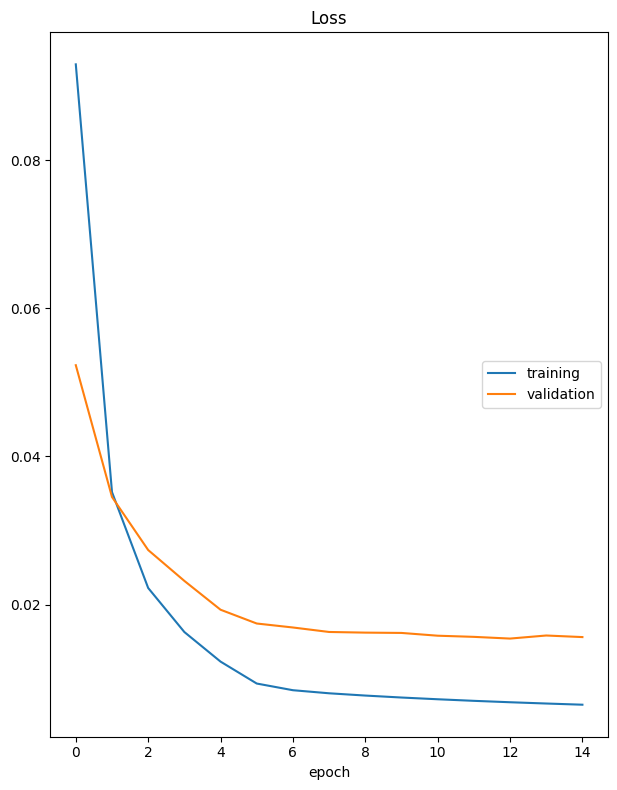

Loss
	training         	 (min:    0.006, max:    0.093, cur:    0.006)
	validation       	 (min:    0.015, max:    0.052, cur:    0.016)
421/421 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0064 - val_loss: 0.0156
0.015607878565788269


In [32]:
#train model with best params
SAMPLES = 20
params = loaded_study.best_params

global train_input_data_padded_normalized, train_gt_data_padded_normalized, gt_scaler
TIME_SERIES_SIZE = params["TIME_SERIES_SIZE"]
train_input_data, train_gt_data = read_data(SAMPLES)
train_gt_data_normalized = normalize_data(train_gt_data, "gt")
train_input_data_normalized = normalize_data(train_input_data, "gnss")
train_input_data_padded_normalized, train_gt_data_padded_normalized = sort_data(TIME_SERIES_SIZE, train_input_data_normalized, train_gt_data_normalized, SAMPLES)

n_layers = params["n_layers"]
activation = params["activation"]
model = Sequential()
model.add(Masking(mask_value=0, input_shape=(train_input_data_padded_normalized.shape[1], train_input_data_padded_normalized.shape[2])))
for i in range(n_layers):
    model.add(LSTM(params[f"n_units_l{i}"] , activation=activation, return_sequences=True))
model.add(Dense(train_gt_data_padded_normalized.shape[2], activation="linear"))

learning_rate = params["learning_rate"]

model.compile(optimizer=Adam(learning_rate), loss="MeanSquaredError")

history = model.fit(train_input_data_padded_normalized, train_gt_data_padded_normalized, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[PlotLossesKeras(), DecimeterError()], validation_split=0.2, verbose=1)
#return validation score as indicator for the model quality
print(history.history["val_loss"][-1])


In [33]:
# visulaize trajectory on map
path_data = read_data(1)

gt_data_normalized = normalize_data(path_data[1], "gt")
gnss_data_normalized = normalize_data(path_data[0], "gnss")
path_input_data_padded_normalized, path_gt_data_padded_normalized = sort_data(TIME_SERIES_SIZE, gnss_data_normalized, gt_data_normalized, 1, model.input_shape[2]-11)

print(model.summary())
print(path_input_data_padded_normalized.shape)

prediction = model.predict(path_input_data_padded_normalized)
prediction = np.array([unnormalize(sample, "gt") for sample in prediction])
gt = np.array([unnormalize(sample, "gt") for sample in path_gt_data_padded_normalized])


predicted_path = prediction[:,-1,0:3]
gt_path = gt[:,-1,0:3]
print(predicted_path.shape)
print(gt_path.shape)
#plot it on a map


m = folium.Map(location=[predicted_path[0,0], predicted_path[0,1]], zoom_start=25, max_zoom=35)

for i in range(len(predicted_path)-1):
    folium.PolyLine([[predicted_path[i,0], predicted_path[i,1]], [predicted_path[i+1,0], predicted_path[i+1,1]]], color="blue").add_to(m)
    folium.PolyLine([[gt_path[i,0], gt_path[i,1]], [gt_path[i+1,0], gt_path[i+1,1]]], color="red").add_to(m)

folium.Marker([predicted_path[-1,0], predicted_path[-1,1]], popup=f"predicted: {predicted_path[-1,0]}, {predicted_path[-1,1]}", icon=folium.Icon(color="red")).add_to(m)
folium.Marker([gt_path[-1,0], gt_path[-1,1]], popup=f"gt: {gt_path[-1,0]}, {gt_path[-1,1]}", icon=folium.Icon(color="red")).add_to(m)

m.save("map.html")





read in 1 samples
normalizing gt data
normalizing gnss data
sample 1 sorted
reading imu data
read in 1 samples
normalizing IMU data
(1300, 12)
batching data
padding train data
(1289, 11, 241)
(1289, 11, 12)
inserting IMU data
(1289, 11, 253)
padding gt data
(1289, 11, 253)
(1288, 11, 7)
(1288, 11, 253)
(1288, 11, 7)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_5 (Masking)             │ (None, 11, 252)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 11, 95)         │       132,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 11, 18)         │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 11, 100)        │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 11, 6)          │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 565,964 (2.16 MB)

 Trainable params: 188,654 (736.93 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 377,310 (1.44 MB)

None
(1288, 11, 252)
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing gt data
unnormalizing g

In [ ]:
#test für Idioten
c = np.arange(24).reshape(2,3,4)
print(c.shape)
for r in c :
    print(r)

c = c.swapaxes(1,2).swapaxes(2,0)
for r in c:
    print(r)
print(c.shape)